In [3]:
import os
import tensorflow as tf
import numpy as np

Import Images From Directory, Build Dataset

In [33]:
# import dataset from directory
DIR_PATH = os.path.join('Detectors', 'cleaned_data', 'sky_dataset_all')
IMAGE_SIZE = 244
BATCH_SIZE = 32
# =============================
# Create Image Dataset form Directory
# =============================
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    DIR_PATH,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='training'

)
ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    DIR_PATH,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='validation'
)

In [4]:
# Visualize data
images = None
labels = None
class_names = ds_train.class_names
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [155]:
for image_batches, label_batches in ds_train:
    print("image batch size:", image_batches.shape)
    break

Pre-Processing, rescaling, augmentation

In [34]:
# data augmentation
with tf.device('/CPU:0'): # for Apple Silicon which does not yet support random() with GPU
    augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomContrast((0.3, 0.8)),
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.02),
    ])

In [35]:
AUTOTUNE = tf.data.AUTOTUNE

augmented_ds_train = ds_train.map(
    lambda x, y: (augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)

augmented_ds_train = augmented_ds_train.cache()
augmented_ds_train = augmented_ds_train.prefetch(buffer_size=10)

Build Model

In [37]:
rescaling = tf.keras.Sequential([
    # rescaling
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [56]:
model = tf.keras.models.Sequential(
    [
        rescaling,
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                      padding='same',
                      kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        # tf.keras.layers.BatchNormalization(axis=3),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                      padding='same',
                      kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        # tf.keras.layers.BatchNormalization(axis=3),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                      padding='same',
                      kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        # tf.keras.layers.BatchNormalization(axis=3),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                      padding='same',
                      kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        # tf.keras.layers.BatchNormalization(axis=3),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(3, activation='softmax')
    ]
)

In [59]:
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, 3))
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (None, 244, 244, 3)       0         
                                                                 
 conv2d_46 (Conv2D)          (None, 244, 244, 64)      1792      
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 122, 122, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 122, 122, 64)      36928     
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 61, 61, 64)      

In [60]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [61]:
history = model.fit(augmented_ds_train, epochs=20, validation_data=ds_val)

Epoch 1/20


2022-11-16 19:55:17.312891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - ETA: 0s - loss: 2.4792 - accuracy: 0.4154

2022-11-16 19:55:18.742590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 3s 233ms/step - loss: 2.4792 - accuracy: 0.4154 - val_loss: 2.1339 - val_accuracy: 0.4186
Epoch 2/20
13/13 [==============================] - 2s 187ms/step - loss: 1.7519 - accuracy: 0.6590 - val_loss: 1.4410 - val_accuracy: 0.6744
Epoch 3/20
13/13 [==============================] - 2s 185ms/step - loss: 1.4095 - accuracy: 0.7205 - val_loss: 1.2314 - val_accuracy: 0.6744
Epoch 4/20
13/13 [==============================] - 2s 186ms/step - loss: 1.1815 - accuracy: 0.7615 - val_loss: 1.0809 - val_accuracy: 0.7674
Epoch 5/20
13/13 [==============================] - 2s 182ms/step - loss: 1.0675 - accuracy: 0.7538 - val_loss: 0.9087 - val_accuracy: 0.8140
Epoch 6/20
13/13 [==============================] - 2s 189ms/step - loss: 0.9695 - accuracy: 0.7923 - val_loss: 0.8520 - val_accuracy: 0.8140
Epoch 7/20
13/13 [==============================] - 2s 194ms/step - loss: 0.9116 - accuracy: 0.8128 - val_loss: 0.7926 - val_accuracy: 0.8372
Epoch 8/20
13/13 

In [62]:
test_loss, test_acc = model.evaluate(ds_val)
print(test_acc)

2/2 [==============================] - 2s 22ms/step - loss: 0.5609 - accuracy: 0.9070
0.9069767594337463


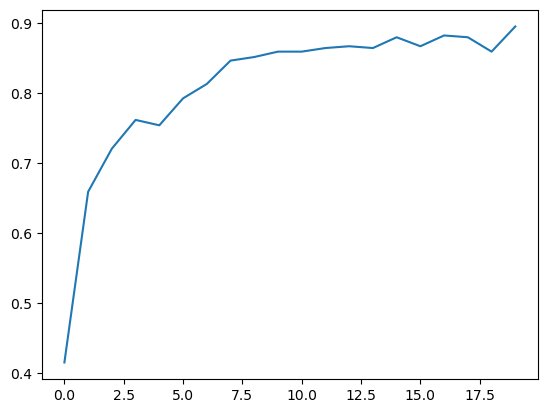

In [64]:
acc = history.history['accuracy']
# print(acc)

plt.plot(acc)
plt.show()

In [4]:
model = tf.keras.models.load_model(os.path.join("models", "sky_recognition_basic_v2.h5"))

Metal device set to: Apple M1 Max


2022-12-03 18:11:04.754015: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-03 18:11:04.754145: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
# test sample images:
import os
import numpy as np
import matplotlib.pyplot as plt
SAMPLE_DIR = os.path.join('Detectors', 'sample_images', 'sky_testing')
IMAGE_SIZE = 244
class_names = ['no_sky', 'sky', 'sunset']

ds_testing = tf.keras.preprocessing.image_dataset_from_directory(
    SAMPLE_DIR,
    label_mode=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=123,
    validation_split=None
)

Found 24 files belonging to 1 classes.


In [10]:
def get_prediction(prediction, _class_names):
    one_hot_array = prediction[0]
    max_confidence = max(one_hot_array)
    if max_confidence < 0.5:
        return 'unsure'
    else:
        return _class_names[one_hot_array.argmax()]

1/1 [==============================] - 0s 10ms/step


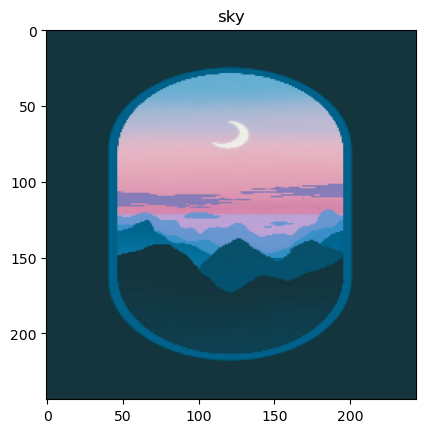

1/1 [==============================] - 0s 9ms/step


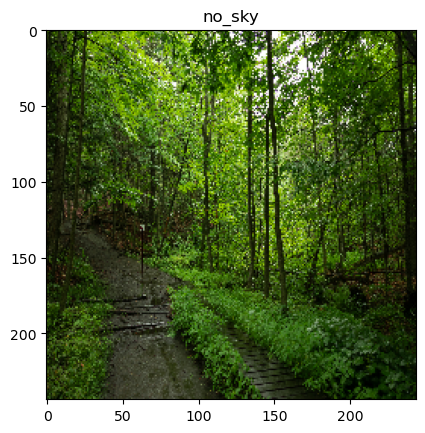

1/1 [==============================] - 0s 9ms/step


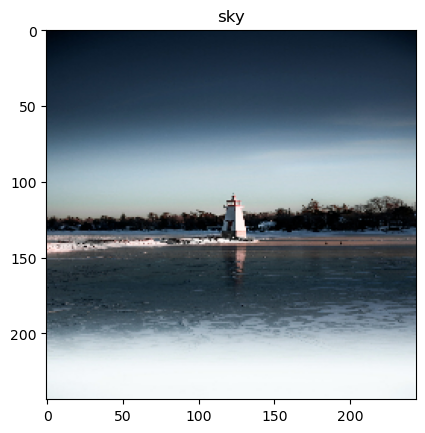

1/1 [==============================] - 0s 10ms/step


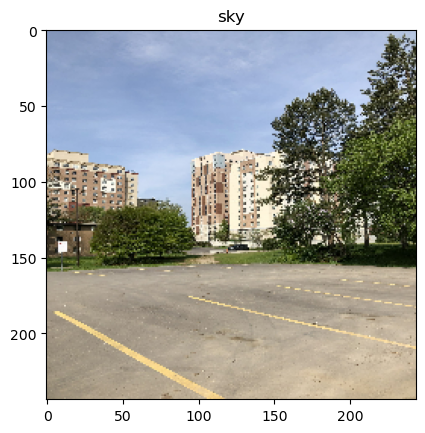

1/1 [==============================] - 0s 9ms/step


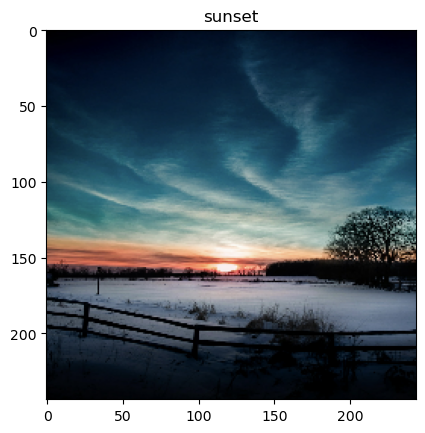

1/1 [==============================] - 0s 12ms/step


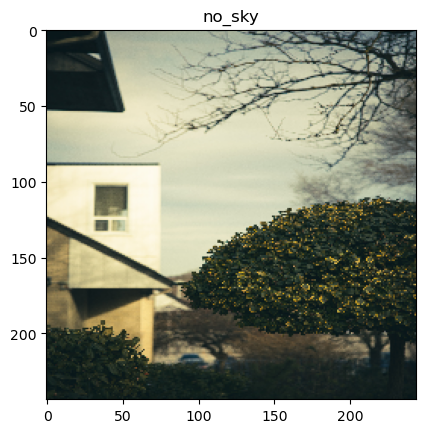

1/1 [==============================] - 0s 13ms/step


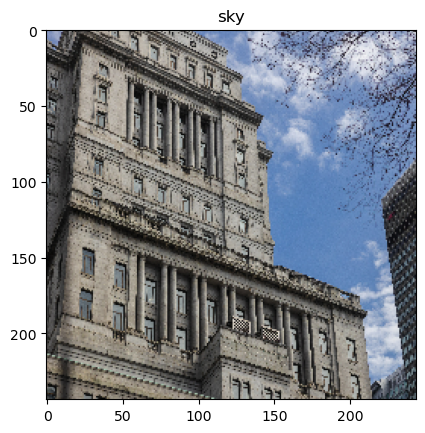

1/1 [==============================] - 0s 9ms/step


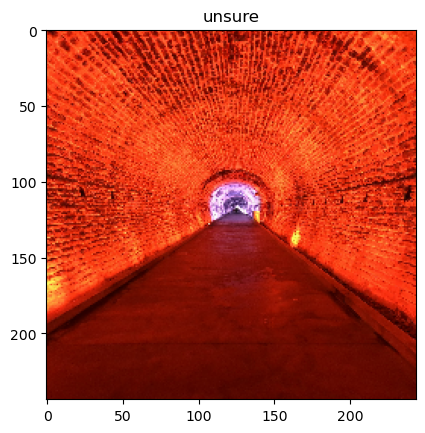

1/1 [==============================] - 0s 9ms/step


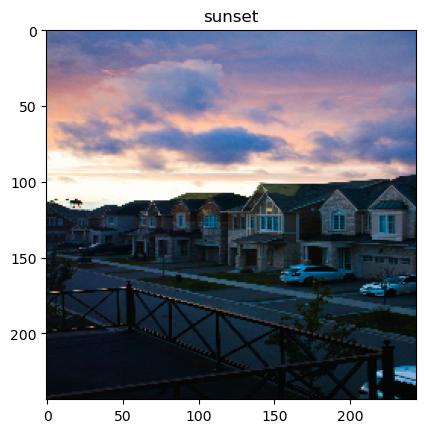

1/1 [==============================] - 0s 8ms/step


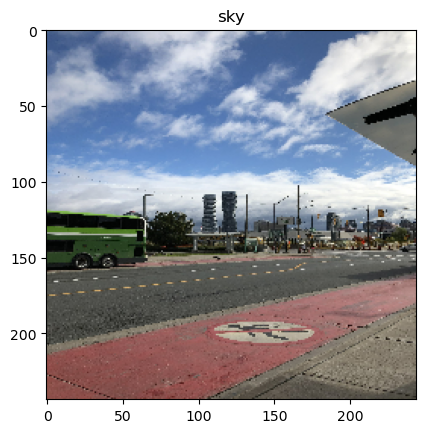

1/1 [==============================] - 0s 10ms/step


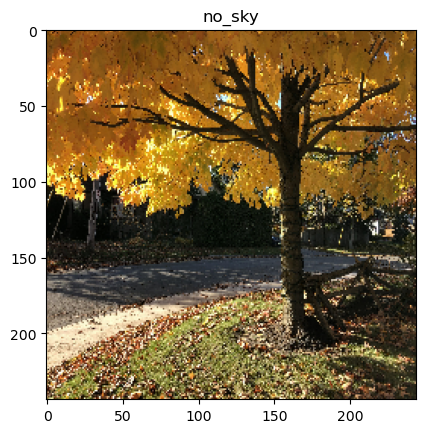

1/1 [==============================] - 0s 9ms/step


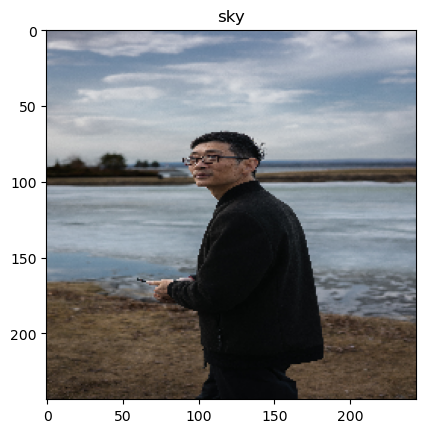

1/1 [==============================] - 0s 9ms/step


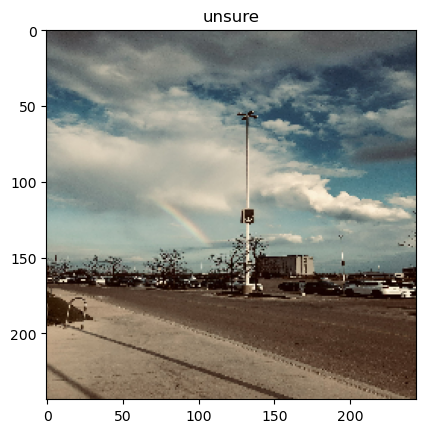

1/1 [==============================] - 0s 10ms/step


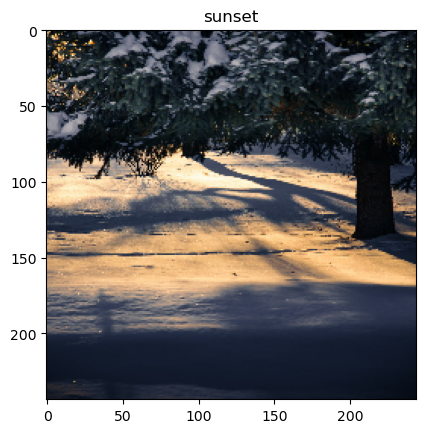

1/1 [==============================] - 0s 8ms/step


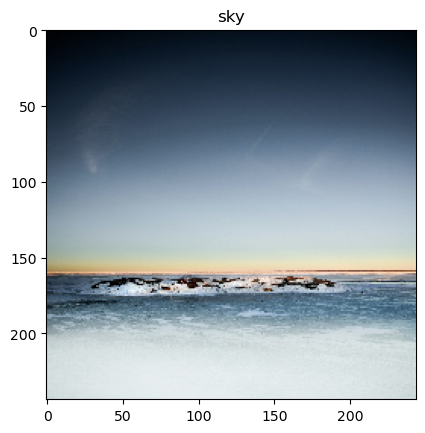

1/1 [==============================] - 0s 8ms/step


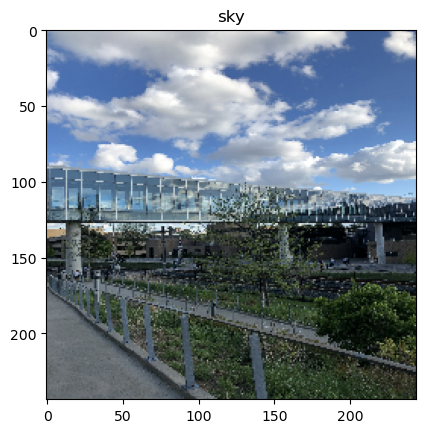

1/1 [==============================] - 0s 9ms/step


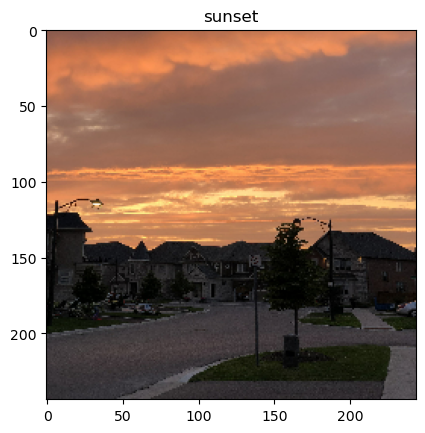

1/1 [==============================] - 0s 10ms/step


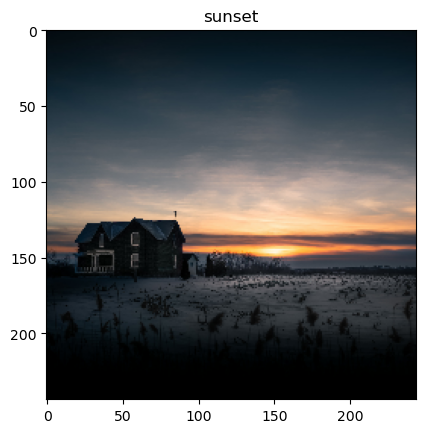

1/1 [==============================] - 0s 9ms/step


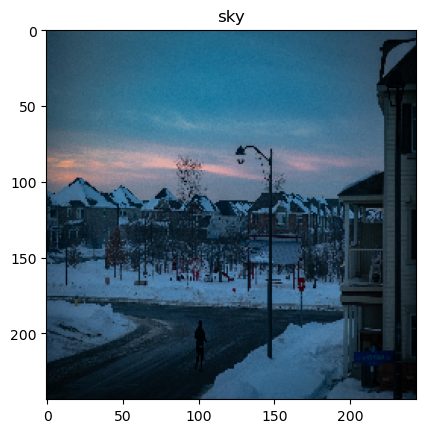

1/1 [==============================] - 0s 9ms/step


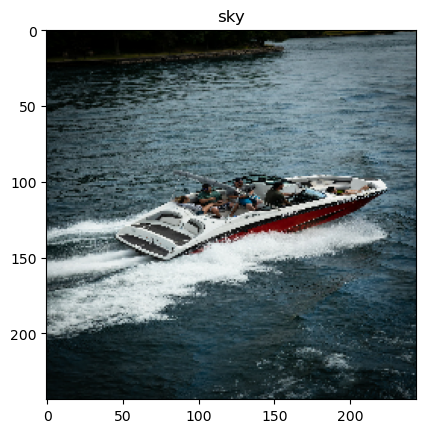

1/1 [==============================] - 0s 9ms/step


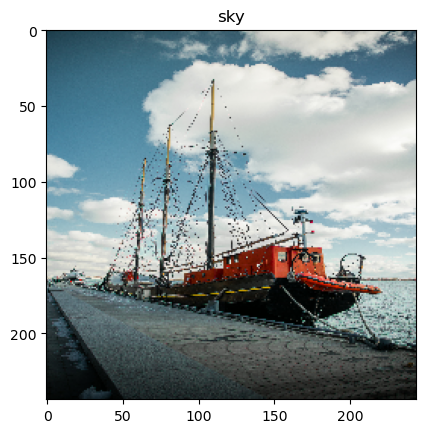

1/1 [==============================] - 0s 10ms/step


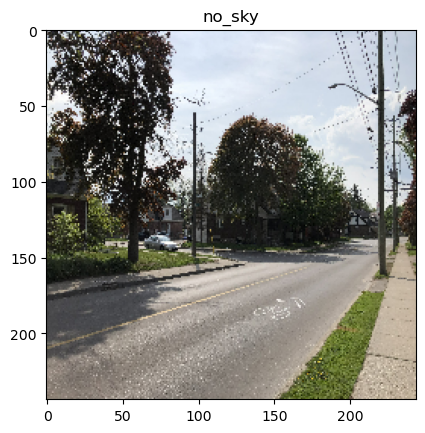

1/1 [==============================] - 0s 8ms/step


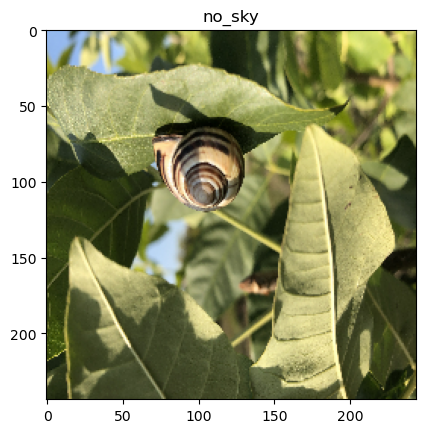

1/1 [==============================] - 0s 9ms/step


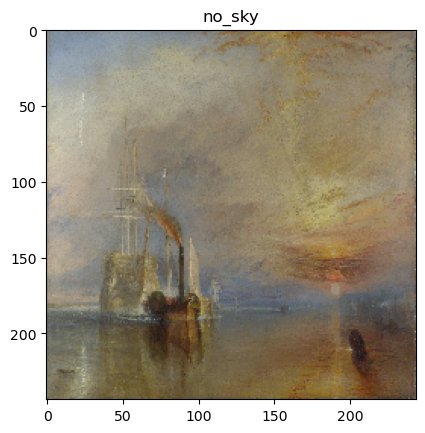

In [11]:
for images in ds_testing:
    for i in range(24):
        image = images[i]
        plt.imshow(image.numpy().astype("uint8"))
        predictions = model.predict(np.expand_dims(image, axis=0))
        plt.title(get_prediction(predictions, class_names))
        plt.show()